In [44]:
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

In [45]:
class Regression:
    
    def __init__(self, feat_dims=0):
        # alpha is weight decay hyperparameter
        
        self.learning_rate =  0.00000001
        self.epochs = 250
        self.batch_size = 100
        
        self.feat_dims = feat_dims
        self.output_classes = 1
        
        # create weights array/matrix size (num features x output)
        self.weights = 0.0001 * np.random.rand(self.feat_dims, self.output_classes)
        self.alpha = 0.5  # regularization strength
        
        self.y_mean = None
        
    def normalize_feat(self, x, mean=None, std=None):
        # normalize the feature data.  test data must pass mean and std
        
        # calc feature-wise mean
        if mean is None:
            mean = np.mean(x, axis=0)
            
        # calc feature-wise std
        if std is None:
            std = np.std(x, axis=0)
        
        # sub the mean per column
        x_norm = x - mean

        # div by the standard dev.
        x_norm = x_norm / std

        return x_norm, mean, std
        
    def load_data(self, fname, bias=1):
        
        data = loadtxt(fname, delimiter=',')
        
        # loads data, normalizes, and appends a bias vector to the data

        TRAIN_NUM = 463714  # training data up to this point

        # process training data
        x_train = data[:TRAIN_NUM,1:].astype(float)  # parse train
        
        x_train, train_mean, train_std = self.normalize_feat(x_train)  # normalize data

        # create a col vector of ones
        col_bias = np.ones((x_train.shape[0], 1))

        # append bias with hstack
        x_train = np.hstack((x_train, col_bias))
        
        # convert label vals to int and to vector
        y_train = data[:TRAIN_NUM,0].astype(int)
        y_train = y_train.reshape((-1, 1))

        # -------------------
        
        # process test data
        x_test = data[TRAIN_NUM:,1:].astype(float)  # parse test
        x_test, _, _ = self.normalize_feat(x_test, train_mean, train_std)  # normalize data

        # create a col vector of ones
        col_bias = np.ones((x_test.shape[0], 1))

        # append bias with hstack
        x_test = np.hstack((x_test, col_bias))    

        # convert label vals to int and to vector
        y_test = data[TRAIN_NUM:,0].astype(int)
        y_test = y_test.reshape((-1, 1))  # convert to column vector
        
        return x_train, y_train, x_test, y_test

    def musicMSE(self, pred, gt):

        # make sure to floor by converting to int()
        diff = pred - gt
        mse = (np.square(diff)).mean()

        return mse
    
    def label_sub_mean(self, label):
        
        # find the mean
        self.y_mean = np.mean(label)
        
        # sub mean
        temp = label - self.y_mean
        
        return temp

    def train_loss(self, x, yt_sm):
        # calc the cost
        # yt = true label, sub mean label
        
        n_samples = x.shape[0]
        
        # predict
        pred_y = np.exp(np.dot(x, self.weights))
        
        # (x dot w)
        x_dot_w = np.dot(x, self.weights)
        
        # calc y dot times x_dot_w
        x_prod_y = x_dot_w * yt_sm
    
        # calc the diff, and divide
        loss = np.sum((pred_y - x_prod_y)) / n_samples
    
        return loss 
    
    def test_loss(self, x, yt_sm):
        # calc the cost at test time
        # yt = true label, is regular label
        # this function adds the y mean back
        
        n_samples = x.shape[0]  

        # predict
        pred_y = np.exp(np.dot(x, self.weights))
    
        # (x dot w)
        x_dot_w = np.dot(x, self.weights)
        
        yt = yt_sm
    
        # calc y dot times x_dot_w
        x_prod_y = x_dot_w * yt
        
    
        # calc the diff, divide, and add the mean
        loss = np.sum((pred_y - x_prod_y)) / n_samples
    
        return loss 
    
    def gradient(self, x, yt_sm):
        
        n_samples = x.shape[0]

        y_pred = np.exp(np.dot(x, self.weights))

        dW = np.dot(x.T, (y_pred - yt_sm).reshape(-1)).reshape(-1, 1)
        
        # return the avg dW
        return dW 

    def calc_mse(self, x, y_sm):
        # preprocesses (adds the y_mean back to both x and y, and calls musicMSE)
        
        # predict
        pred_y = np.dot(x, self.weights)
        
        # add the y mean to the pred and convert to int to round
#         pred_y += self.y_mean
        
        # convert to int to round
        pred_y = pred_y
        
        # convert to int to round
        y_labels = y_sm
        
        # calc the MSE
        mse = self.musicMSE(pred_y, y_labels)
        
        return mse, pred_y

    def train_phase(self, x_train, y_train_sm):
        # shuffle data together, and forward prop by batch size, and add momentum

        num_train = x_train.shape[0]
        losses = []
        # Randomize the data (using sklearn shuffle)
        x_train, y_train_sm = shuffle(x_train, y_train_sm)

        # get the next batch (loop through number of training samples, step by batch size)
        for i in range(0, num_train, self.batch_size):

            # grab the next batch size
            x_train_batch = x_train[i:i + self.batch_size]
            y_train_batch_sm = y_train_sm[i:i + self.batch_size]

            # calc loss
            loss = self.train_loss(x_train_batch, y_train_batch_sm)
            
            dW = self.gradient(x_train_batch, y_train_batch_sm)
            
            self.weights -= dW * self.learning_rate  # update the weights
            
            losses.append(loss)  # save the losses

        return np.average(losses)  # return the average

    def test_phase(self, x, y_sm):
        # extra, but more explicit calc of loss and gradient during testing (no back prop)
        
        # calc loss
        loss = self.test_loss(x, y_sm)
        
        return loss
        
    def run_epochs(self, x_train, y_train_sm, x_test, y_test_sm):
        # start the training/valid by looping through epochs

        # store losses and accuracies here
        train_losses = []
        test_losses = []
        train_mse_arr = []
        test_mse_arr = []

        for e in range(self.epochs): # loop through epochs

            print('Epoch {} / {}...'.format(e + 1, self.epochs))

            # calc loss and accuracies
            train_loss = self.train_phase(x_train, y_train_sm)
            test_loss = self.test_phase(x_test, y_test_sm)
            
            train_mse, train_preds = self.calc_mse(x_train, y_train_sm)
            test_mse, test_preds = self.calc_mse(x_test, y_test_sm)

            # append vals to lists
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_mse_arr.append(train_mse)
            test_mse_arr.append(test_mse)
            
            print('train loss: ', train_loss)
            print('test loss: ', test_loss)
            print('train MSE: ', train_mse)
            print('test MSE: ', test_mse)
        
#         return train_losses, test_losses

        # return all the vals
        return train_losses, test_losses, train_mse_arr, test_mse_arr, test_preds
    
    def plot_graph(self, train_losses, test_losses, train_mse, test_mse):
        # plot graph
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label="Train loss")
        plt.plot(test_losses, label="Test loss")
        plt.legend(loc='best')
        plt.title("Poisson: Loss vs. Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("MSE")

        plt.subplot(1, 2, 2)
        plt.plot(train_mse, label="Train MSE")
        plt.plot(test_mse, label="Test MSE")
        plt.legend(loc='best')
        plt.title("Poisson: MSE vs. Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("MSE")
        plt.show()
        
    def plot_weights(self):
        
        plt.hist(self.weights, bins=12)
        plt.xlabel('bins')
        plt.ylabel('count')
        plt.title('Lasso Regression Weights Histogram')
        plt.show()


In [46]:
# create Regression() object to load data
regr = Regression()

In [47]:
# # load the data
# fname = 'YearPredictionMSD.txt'
# x_train, y_train, x_test, y_test = regr.load_data(fname)

In [48]:
# ==========  Poisson Regression Training  =============

feat_dims = x_train.shape[1]

# create Regression() object to run training
regr = Regression(feat_dims)

# convert labels to floats
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# sub mean from y labels
y_train_sm = regr.label_sub_mean(y_train)
y_test_sm = regr.label_sub_mean(y_test)

train_losses, test_losses, train_mse_arr, test_mse_arr, test_preds = regr.run_epochs(x_train, y_train_sm, x_test, y_test_sm)



Epoch 1 / 250...
train loss:  0.8919680467929182
test loss:  0.7885788332697007
train MSE:  119.25695790700757
test MSE:  117.34768365072888
Epoch 2 / 250...
train loss:  0.6800086558031794
test loss:  0.5841211885639227
train MSE:  118.84973802335065
test MSE:  116.9466871872668
Epoch 3 / 250...
train loss:  0.47505868731726447
test loss:  0.3864746972991066
train MSE:  118.45650056099974
test MSE:  116.55981161496548
Epoch 4 / 250...
train loss:  0.2766286915617388
test loss:  0.19534714453261123
train MSE:  118.07662989049592
test MSE:  116.18648771721459
Epoch 5 / 250...
train loss:  0.08449900513335215
test loss:  0.010571674803389471
train MSE:  117.70966153771472
test MSE:  115.82630879469545
Epoch 6 / 250...
train loss:  -0.10144225562653703
test loss:  -0.1679446871661665
train MSE:  117.35524004397142
test MSE:  115.47895383094453
Epoch 7 / 250...
train loss:  -0.2813248390894366
test loss:  -0.3402494489465784
train MSE:  117.01307998561298
test MSE:  115.14416716040644
Epoc

train loss:  -4.856803826691194
test loss:  -4.586326515081904
train MSE:  109.3974722472609
test MSE:  108.05546494184075
Epoch 60 / 250...
train loss:  -4.909248548361138
test loss:  -4.635998147349997
train MSE:  109.33496971344606
test MSE:  108.00028719385114
Epoch 61 / 250...
train loss:  -4.9631778402492595
test loss:  -4.68544080732812
train MSE:  109.27342972112035
test MSE:  107.94591355239605
Epoch 62 / 250...
train loss:  -5.014674186988866
test loss:  -4.734479997353287
train MSE:  109.21228778831961
test MSE:  107.89175240489253
Epoch 63 / 250...
train loss:  -5.064631668973413
test loss:  -4.7831196444536825
train MSE:  109.15363473523247
test MSE:  107.8401462935015
Epoch 64 / 250...
train loss:  -5.117128998091533
test loss:  -4.831339776573294
train MSE:  109.0963104605727
test MSE:  107.7898030107343
Epoch 65 / 250...
train loss:  -5.168230303934679
test loss:  -4.879264698489105
train MSE:  109.04020789147907
test MSE:  107.74061424513482
Epoch 66 / 250...
train los

train loss:  -7.509489516484919
test loss:  -7.099074474207232
train MSE:  107.19741643384512
test MSE:  106.17838419370763
Epoch 118 / 250...
train loss:  -7.548223689565908
test loss:  -7.13814393579772
train MSE:  107.17734925699234
test MSE:  106.16292736861553
Epoch 119 / 250...
train loss:  -7.586838097681849
test loss:  -7.1771569530439745
train MSE:  107.15748514320204
test MSE:  106.14757368972269
Epoch 120 / 250...
train loss:  -7.626447976618238
test loss:  -7.21611727990875
train MSE:  107.13737324400115
test MSE:  106.13182875626532
Epoch 121 / 250...
train loss:  -7.671423250047159
test loss:  -7.255012558104677
train MSE:  107.11755862548873
test MSE:  106.11641545057168
Epoch 122 / 250...
train loss:  -7.711208217162784
test loss:  -7.293689403173662
train MSE:  107.09971903128582
test MSE:  106.10307200575797
Epoch 123 / 250...
train loss:  -7.752513570642096
test loss:  -7.3323252408229775
train MSE:  107.0819867267596
test MSE:  106.0898024824574
Epoch 124 / 250...
t

train loss:  -9.744404909614062
test loss:  -9.226315049982537
train MSE:  106.71234077070152
test MSE:  105.93217396194069
Epoch 176 / 250...
train loss:  -9.77934249401504
test loss:  -9.260944910847003
train MSE:  106.71500445166872
test MSE:  105.93858587114315
Epoch 177 / 250...
train loss:  -9.816272803807323
test loss:  -9.295535281825563
train MSE:  106.71729323489093
test MSE:  105.94450935683584
Epoch 178 / 250...
train loss:  -9.857274064523956
test loss:  -9.329933262410751
train MSE:  106.72169223557948
test MSE:  105.95276731100579
Epoch 179 / 250...
train loss:  -9.89802508827268
test loss:  -9.364386544671682
train MSE:  106.72512272829941
test MSE:  105.95986708339288
Epoch 180 / 250...
train loss:  -9.924135175883617
test loss:  -9.398681973207543
train MSE:  106.72940325606643
test MSE:  105.96789419218399
Epoch 181 / 250...
train loss:  -9.966898377833969
test loss:  -9.432874412446171
train MSE:  106.73424937676228
test MSE:  105.97652745180669
Epoch 182 / 250...
t

train loss:  -11.737822418629948
test loss:  -11.110997479165507
train MSE:  107.40635917996994
test MSE:  106.82760265801954
Epoch 233 / 250...
train loss:  -11.775048740788645
test loss:  -11.14267848357873
train MSE:  107.427462777768
test MSE:  106.8520168862893
Epoch 234 / 250...
train loss:  -11.808918328757972
test loss:  -11.174244666574593
train MSE:  107.44965619567824
test MSE:  106.87756905203521
Epoch 235 / 250...
train loss:  -11.838135564458446
test loss:  -11.205915566770638
train MSE:  107.47120101028324
test MSE:  106.9023071359818
Epoch 236 / 250...
train loss:  -11.870184763220077
test loss:  -11.23757115368243
train MSE:  107.49203041994183
test MSE:  106.9262528184145
Epoch 237 / 250...
train loss:  -11.902261910968456
test loss:  -11.269015964284538
train MSE:  107.51608215128346
test MSE:  106.95378029724063
Epoch 238 / 250...
train loss:  -11.9422726968428
test loss:  -11.300527855438235
train MSE:  107.53780196218584
test MSE:  106.97869479891992
Epoch 239 / 2

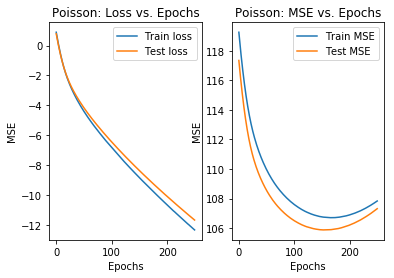

In [49]:
# plot loss and accuracies graphs

regr.plot_graph(train_losses, test_losses, train_mse_arr, test_mse_arr)

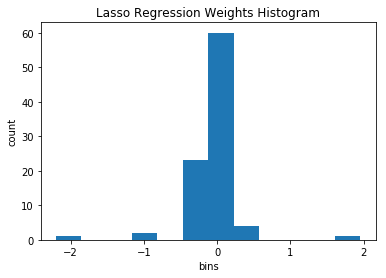

In [50]:
# plot the weights
regr.plot_weights()